In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
from PIL import Image

# JSON 파일 로드
with open('../train.json', 'r') as f:
    data = json.load(f)

# 데이터프레임 생성을 위한 리스트
annotations_list = []

# 어노테이션 정보 추출
for item in data:
    img_info = item['images']
    for ann in item['annotations']:
        # annotations_info 문자열을 리스트로 변환
        bbox = eval(ann['annotations_info'])  # [x, y, w, h] 형식
        
        # bbox 좌표 계산
        x_min = bbox[0]
        y_min = bbox[1]
        width = bbox[2]
        height = bbox[3]
        x_max = x_min + width
        y_max = y_min + height
        
        annotations_list.append({
            'image_id': img_info['img_id'],
            'width': img_info['img_width'],
            'height': img_info['img_height'],
            'category_id': ann['lbl_id'],
            'category_name': ann['lbl_nm'],
            'bbox': bbox,
            'x_min': x_min,
            'y_min': y_min,
            'x_max': x_max,
            'y_max': y_max,
            'width': width,
            'height': height,
            'confidence': ann['confidence']
        })

# DataFrame 생성
train_df = pd.DataFrame(annotations_list)

# 결과 확인
train_df.head()

image_id   width  height  category_id category_name  \
0  0000000031  181.96   29.18            1           bus   
1  0000000031  211.93  209.53            2           car   
2  0000000031   74.97   25.80            2           car   
3  0000000031   89.03   65.41            2           car   
4  0000000031   54.40   27.09            2           car   

                               bbox    x_min   y_min    x_max   y_max  \
0  [1592.74, 442.72, 181.96, 29.18]  1592.74  442.72  1774.70  471.90   
1   [945.6, 769.93, 211.93, 209.53]   945.60  769.93  1157.53  979.46   
2      [414.53, 491.4, 74.97, 25.8]   414.53  491.40   489.50  517.20   
3   [1111.47, 557.14, 89.03, 65.41]  1111.47  557.14  1200.50  622.55   
4     [1496.1, 474.41, 54.4, 27.09]  1496.10  474.41  1550.50  501.50   

   confidence  
0           1  
1           1  
2           1  
3           1  
4           1

In [14]:
import plotly.express as px

fig = px.histogram(train_df.image_id.value_counts(), 
                   log_y=True, color_discrete_sequence=['indianred'], opacity=0.7,
                   labels={"value":"Number of Annotations Per Image"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER IMAGE   " \
                         "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique Images</b>",
                  yaxis_title="<b>Count of All Object Annotations</b>",)
fig.show()

In [15]:
fig = px.histogram(train_df.groupby('image_id')["category_id"].unique().apply(lambda x: len(x)), 
             log_y=True, color_discrete_sequence=['skyblue'], opacity=0.7,
             labels={"value":"Number of Unique class"},
             title="<b>DISTRIBUTION OF # OF Unique Class PER IMAGE   " \
                   "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique CLASS</b>",
                  yaxis_title="<b>Count of Unique IMAGE</b>",)
fig.show()

In [16]:
import seaborn as sns

LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

fig = px.bar(train_df.category_name.value_counts().sort_index(), 
             color=train_df.category_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>")

fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>",
                  yaxis=dict(rangemode='nonnegative'))  # y축을 0부터 시작하도록 설정

fig.show()

100%|██████████| 123151/123151 [00:02<00:00, 57172.87it/s]


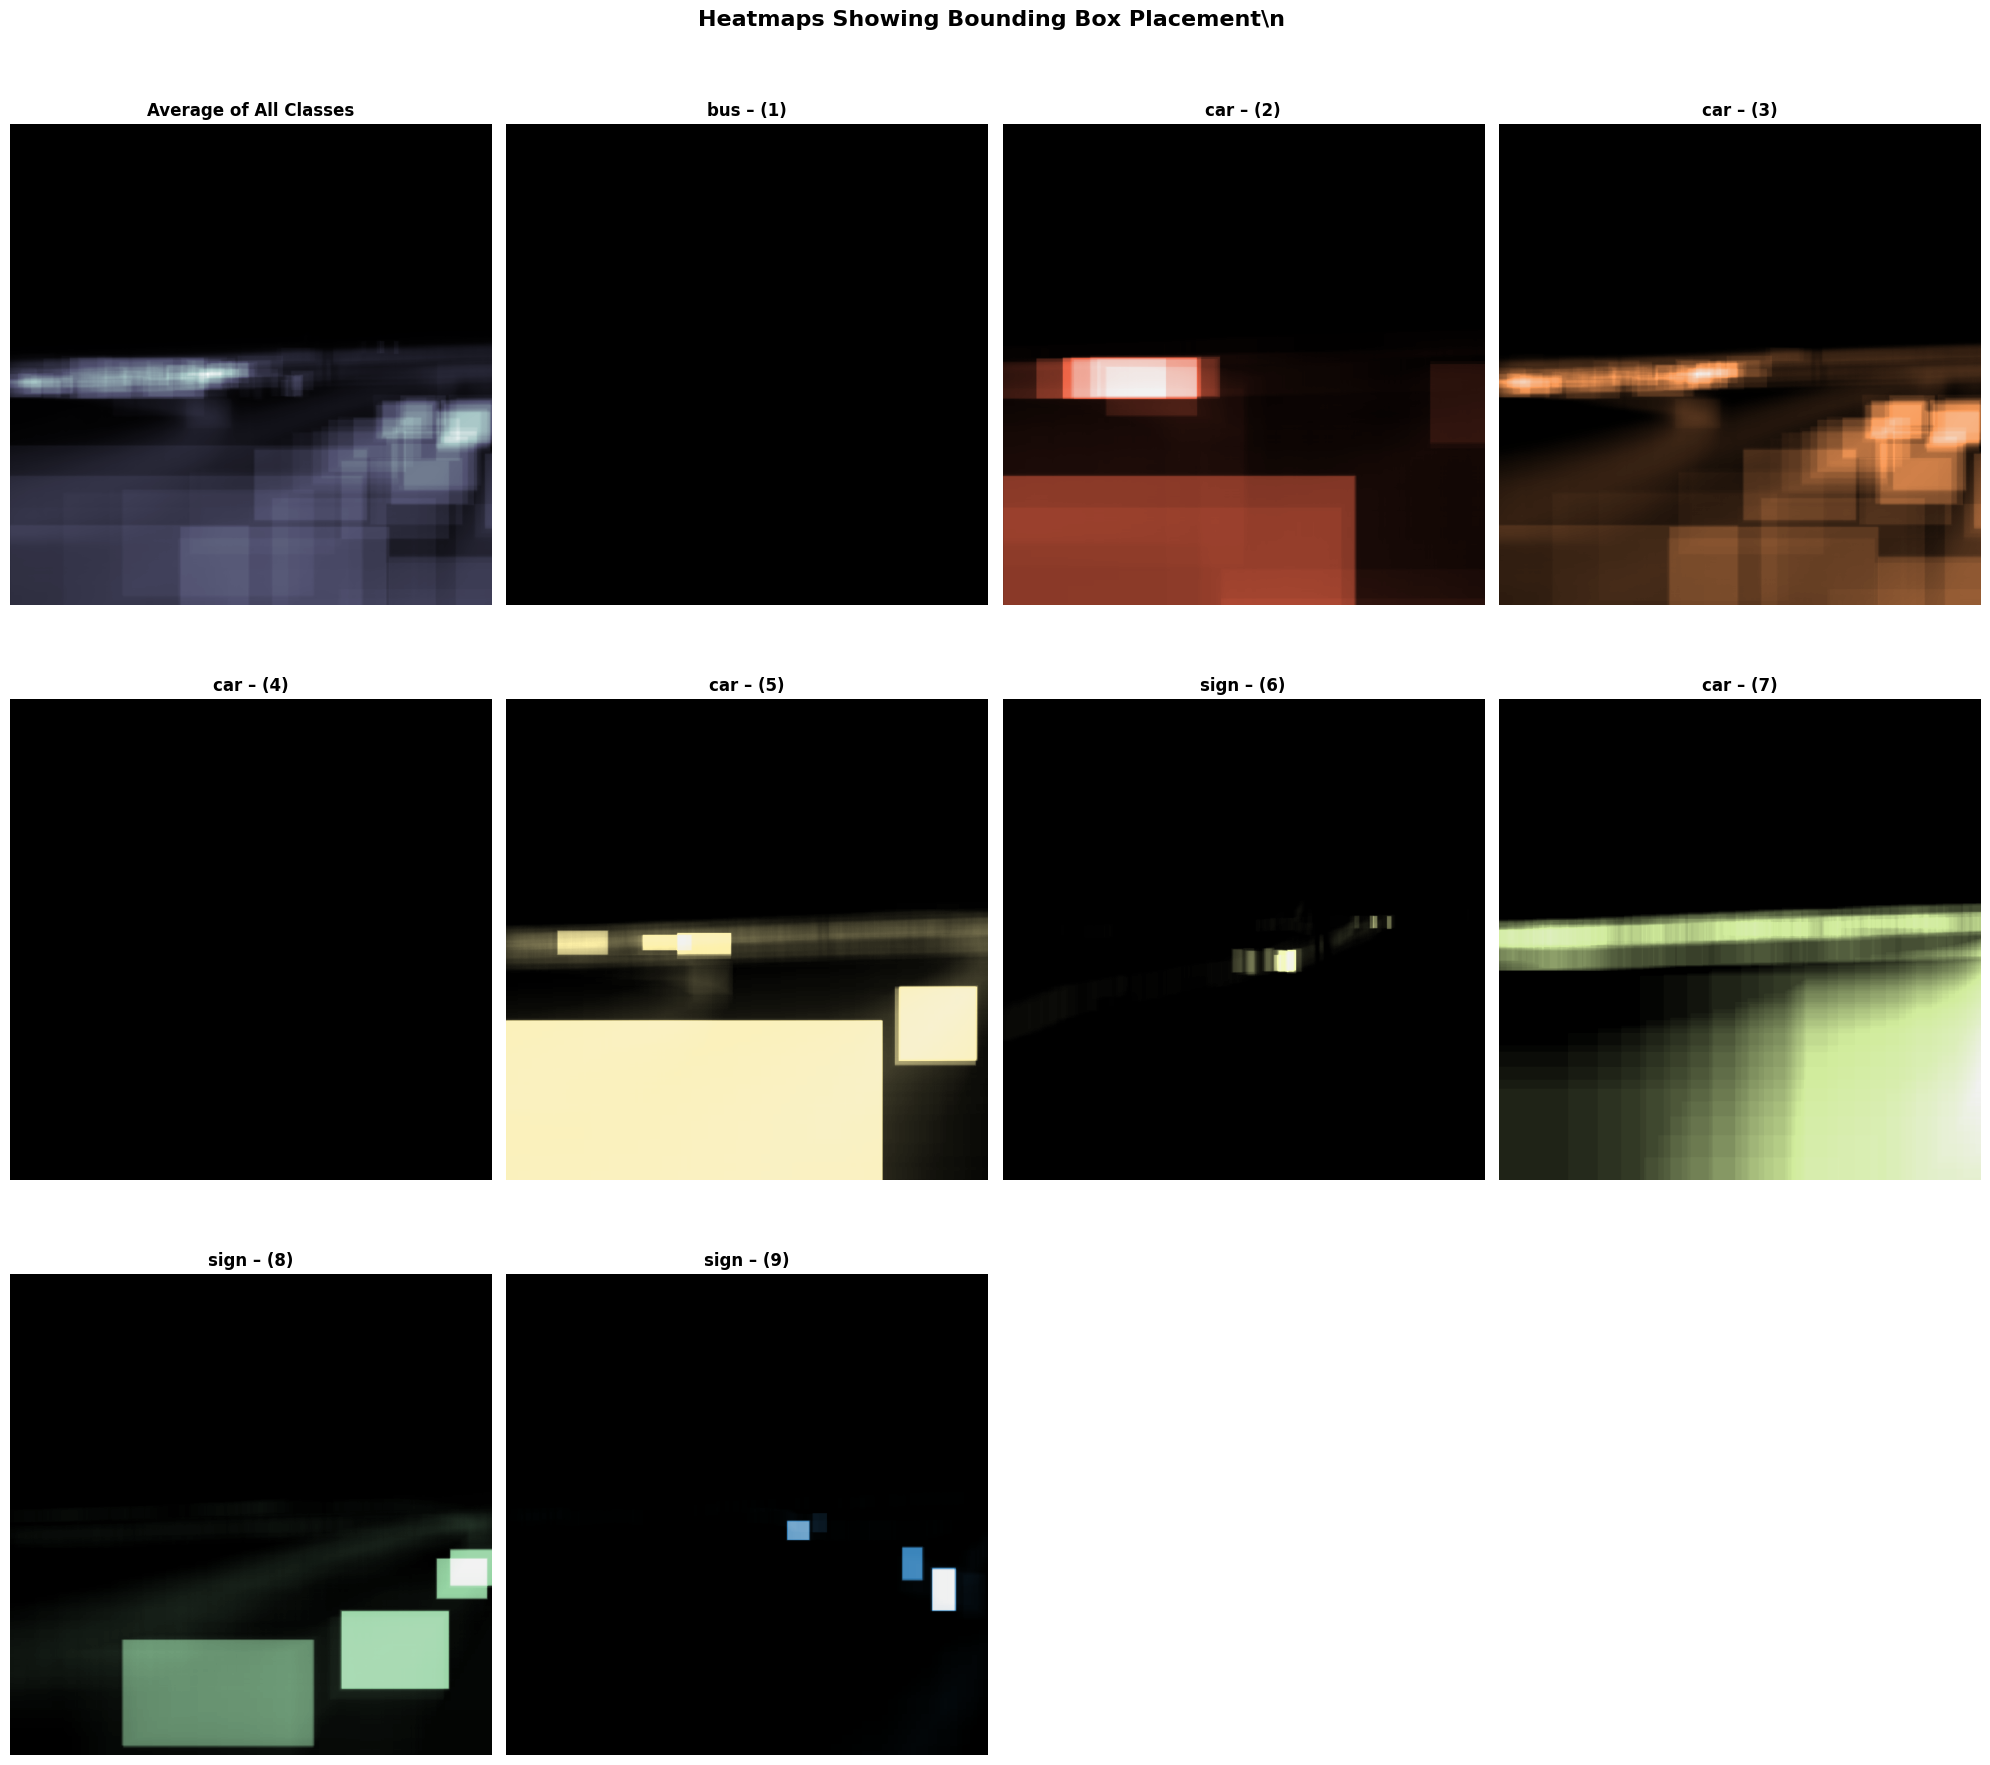

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib

bbox_df = pd.DataFrame()
bbox_df['category_id'] = train_df['category_id'].values
bbox_df['category_name'] = train_df['category_name'].values
bbox_df['x_min'] = train_df['x_min'].values / 1024
bbox_df['x_max'] = train_df['x_max'].values / 1024
bbox_df['y_min'] = train_df['y_min'].values / 1024
bbox_df['y_max'] = train_df['y_max'].values / 1024
bbox_df['frac_x_min'] = train_df['x_min'].values / 1024
bbox_df['frac_x_max'] = train_df['x_max'].values / 1024
bbox_df['frac_y_min'] = train_df['y_min'].values / 1024
bbox_df['frac_y_max'] = train_df['y_max'].values / 1024

ave_src_img_height = 1024
ave_src_img_width = 1024

# DEFAULT
HEATMAP_SIZE = (ave_src_img_height, ave_src_img_width, 14)

# Initialize
heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = bbox_df[["category_id", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= ave_src_img_width
bbox_np[:, 3:5] *= ave_src_img_height
bbox_np = np.floor(bbox_np).astype(np.int16)

# Color map stuff
custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)], 
        name=f"custom_{i}") for i,c in enumerate(sns.color_palette("Spectral", 10))
]
custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1
    
fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\\n ", fontweight="bold", fontsize=16)
for i in range(10):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold")
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{train_df.category_name[i-1]} – ({i})", fontweight="bold")
        
    plt.axis(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Trying to read image: ../train\0000000826.jpg
Trying to read image: ../train\0000008631.jpg
Trying to read image: ../train\0000003001.jpg
Trying to read image: ../train\0000005147.jpg
Trying to read image: ../train\0000006818.jpg
Trying to read image: ../train\0000015789.jpg
Trying to read image: ../train\0000009508.jpg
Trying to read image: ../train\0000012654.jpg
Trying to read image: ../train\0000004198.jpg


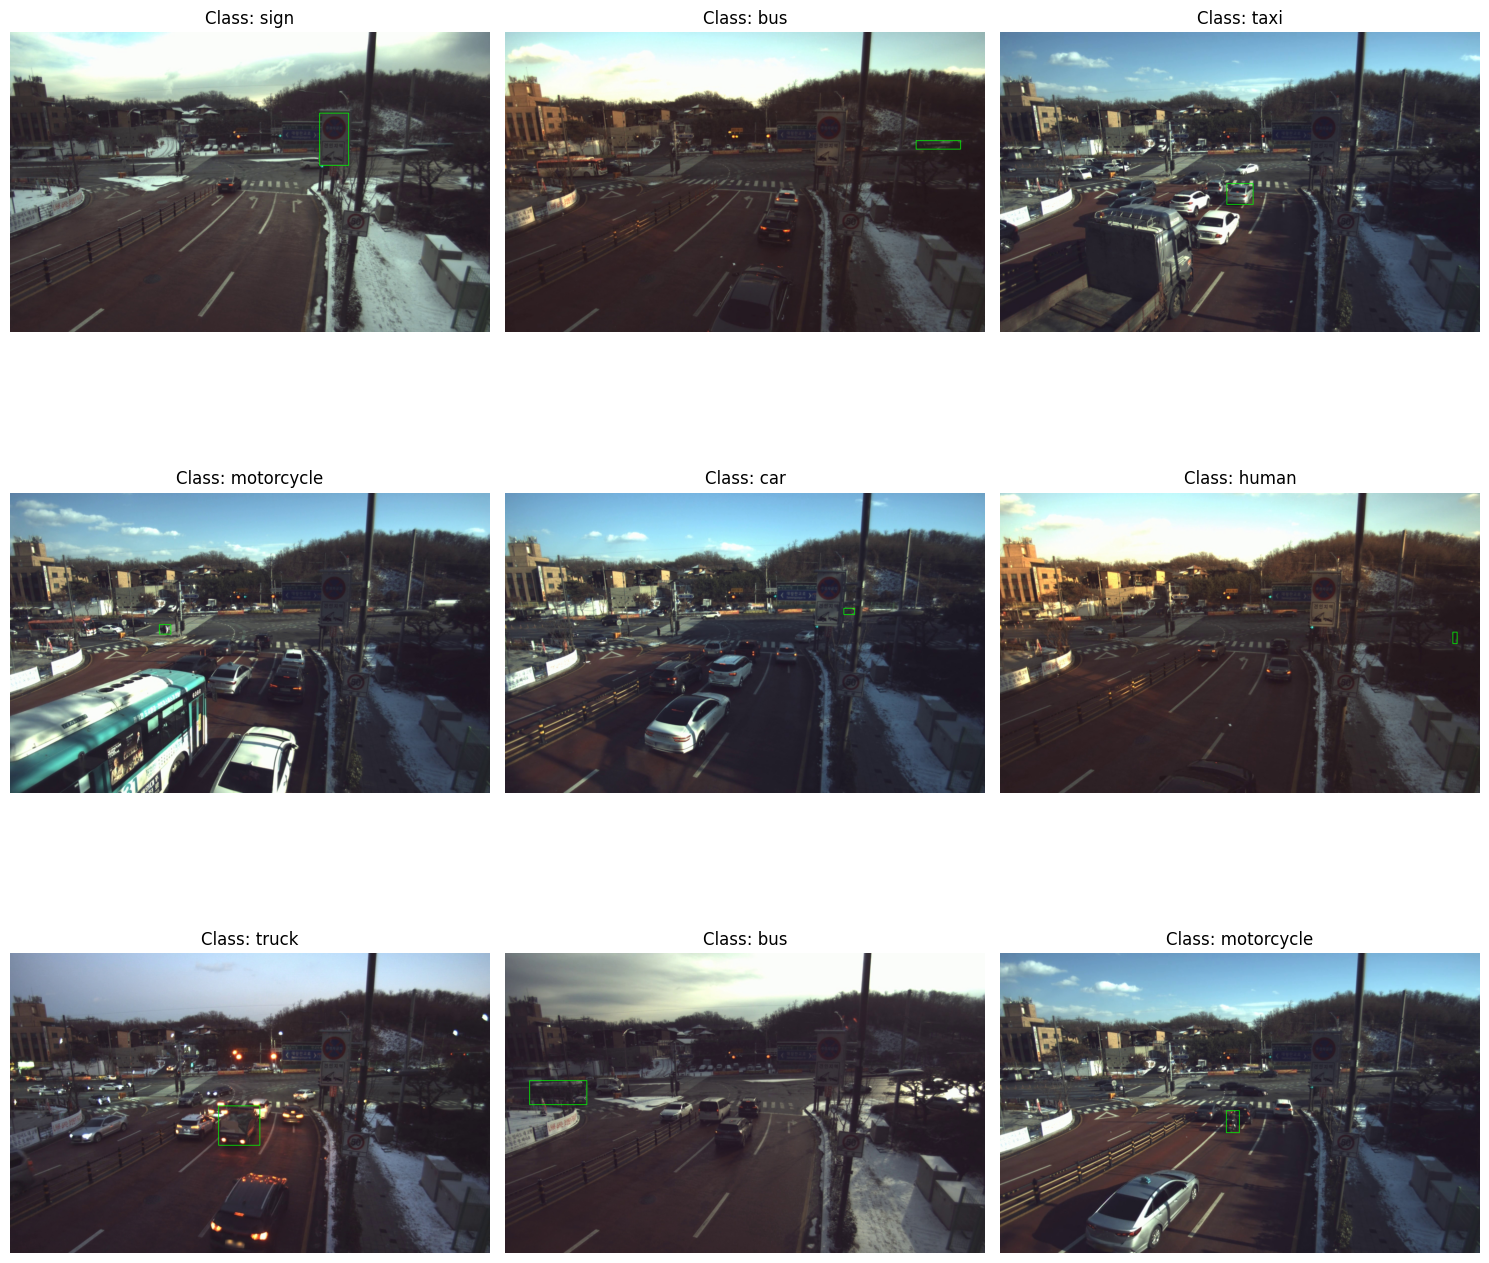

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

classes = train_df['category_name'].unique()

def draw_box(image, box, color=(0, 255, 0), thickness=2):
    x_min, y_min, x_max, y_max = map(int, box)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
    return image

def show_sample_images(df, classes, image_dir, num_samples=9):
    # 각 클래스별로 랜덤하게 이미지 선택
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    samples = []
    for class_name in classes:
        class_samples = df[df['category_name'] == class_name].sample(min(3, len(df[df['category_name'] == class_name])))
        samples.extend(class_samples.to_dict('records'))
    
    np.random.shuffle(samples)
    samples = samples[:num_samples]
    
    for idx, sample in enumerate(samples):
        # 이미지 경로 수정 - .jpg 확장자 추가
        image_path = os.path.join(image_dir, f"{sample['image_id']}.jpg")
        print(f"Trying to read image: {image_path}")  # 디버깅을 위한 출력
        
        # 이미지 읽기 시도
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        box = [sample['x_min'], sample['y_min'], sample['x_max'], sample['y_max']]
        image_with_box = draw_box(image.copy(), box)
        
        axes[idx].imshow(image_with_box)
        axes[idx].set_title(f"Class: {sample['category_name']}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# 이미지 디렉토리 경로 설정 (실제 이미지가 있는 경로로 수정)
image_dir = '../train'

# 함수 호출
show_sample_images(train_df, classes, image_dir)

클래스별 샘플 수와 비율:
--------------------------------------------------
car             : 77368 samples ( 62.82%)
sign            : 21001 samples ( 17.05%)
human           :  9734 samples (  7.90%)
truck           :  5159 samples (  4.19%)
bus             :  4662 samples (  3.79%)
taxi            :  2651 samples (  2.15%)
motorcycle      :  1609 samples (  1.31%)
special_vehicles :   967 samples (  0.79%)

총 샘플 수: 123151


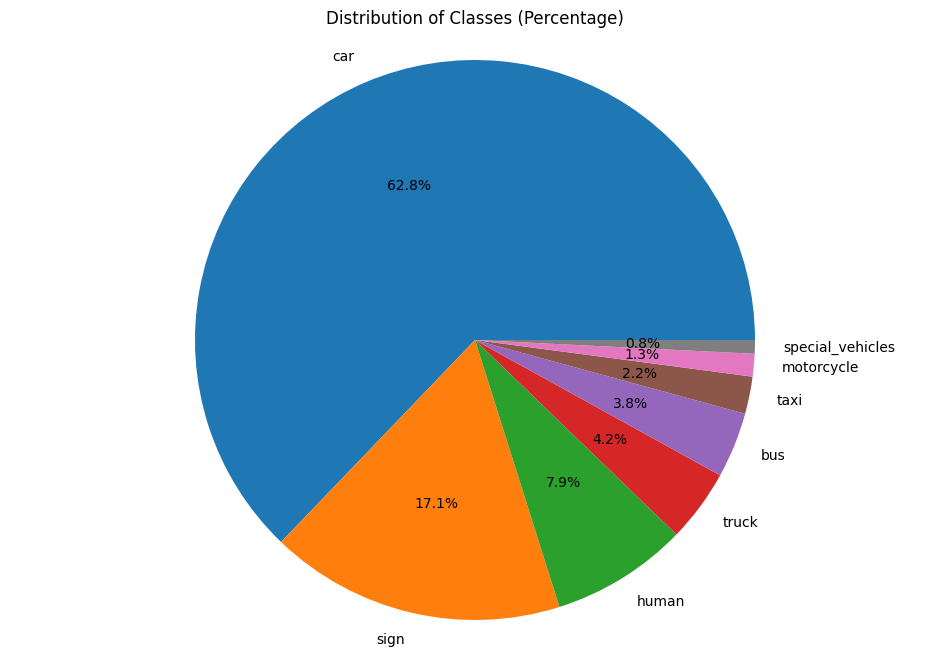

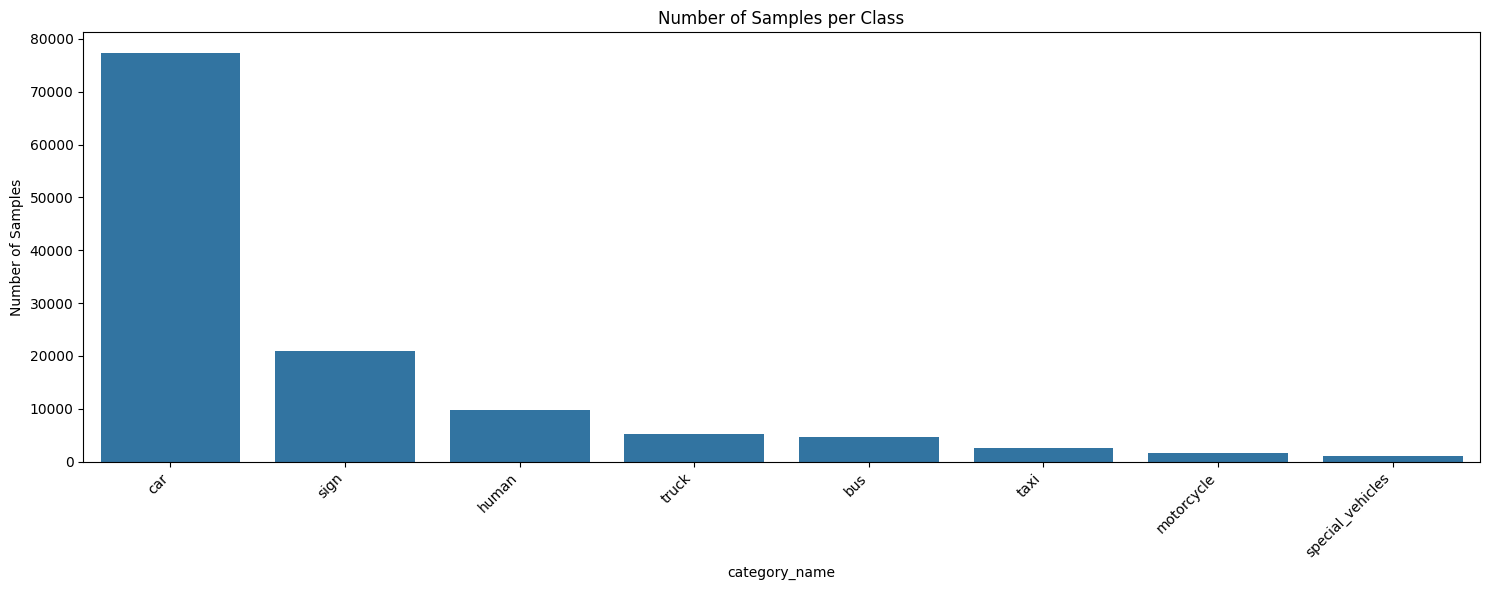

In [21]:
# 모든 클래스의 분포 확인
class_distribution = train_df['category_name'].value_counts()
total_samples = len(train_df)

print("클래스별 샘플 수와 비율:")
print("-" * 50)
for class_name, count in class_distribution.items():
    percentage = (count / total_samples) * 100
    print(f"{class_name:<15} : {count:>5} samples ({percentage:>6.2f}%)")

print("\n총 샘플 수:", total_samples)

# 시각화: 파이 차트로 비율 표시
plt.figure(figsize=(12, 8))
plt.pie(class_distribution.values, labels=class_distribution.index, autopct='%1.1f%%')
plt.title('Distribution of Classes (Percentage)')
plt.axis('equal')
plt.show()

# 막대 그래프로 샘플 수 표시
plt.figure(figsize=(15, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Samples per Class')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

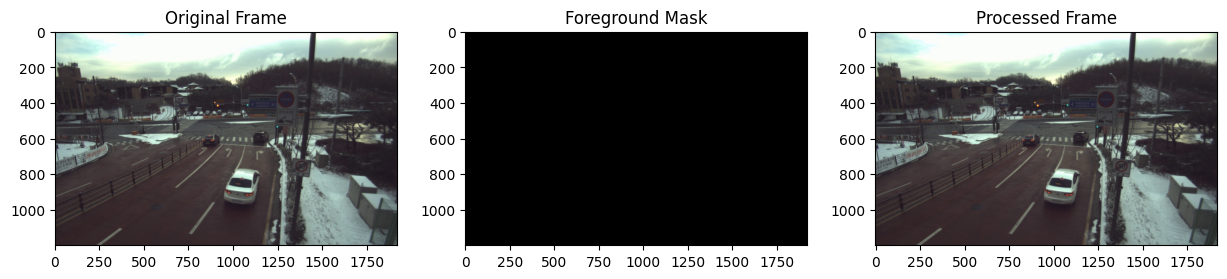

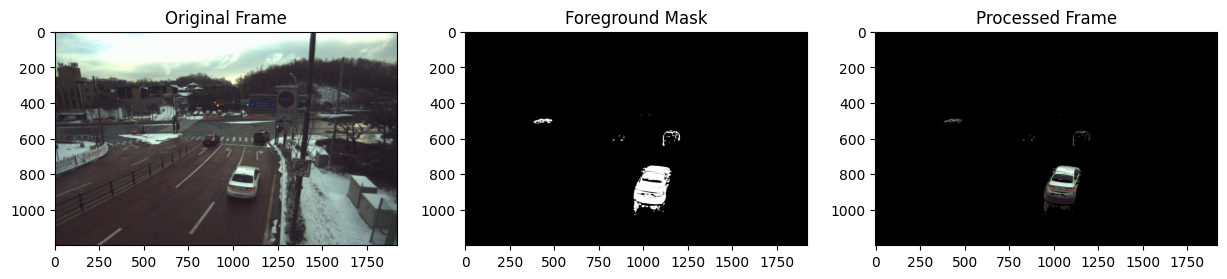

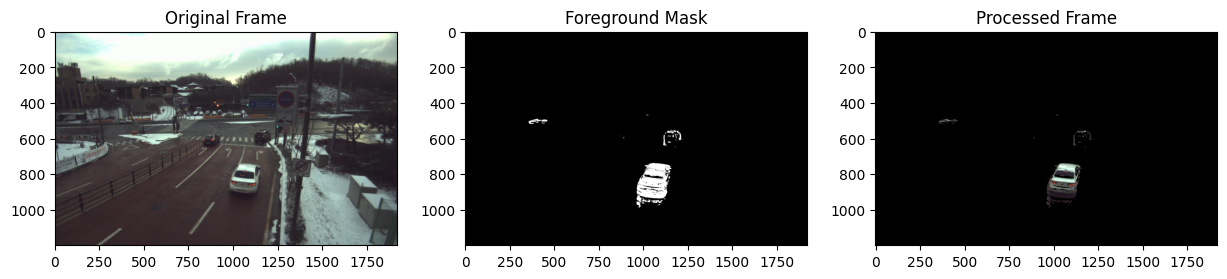

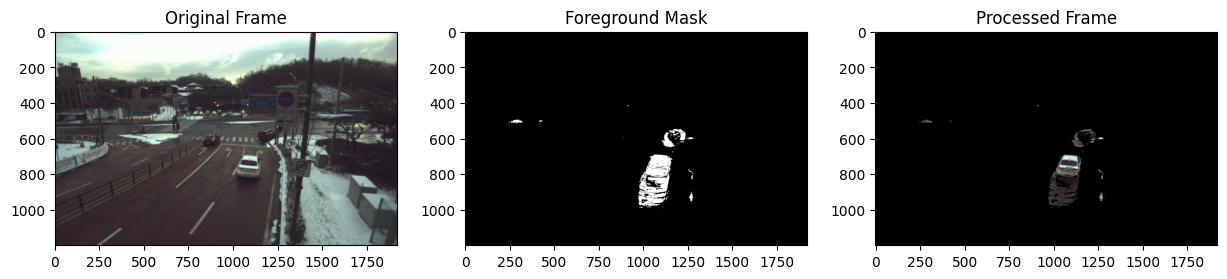

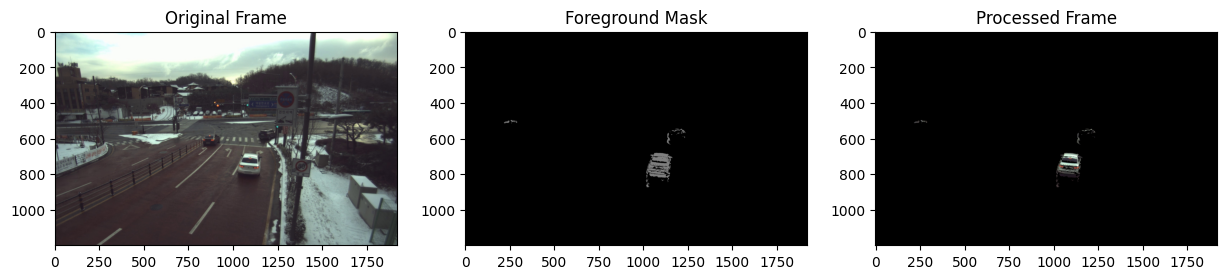

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_background_subtraction(frames, visualize=True):
    # BackgroundSubtractorMOG2: 가우시안 혼합 모델 기반 배경 제거기
    backSub = cv2.createBackgroundSubtractorMOG2(
        history=500,  # 배경 모델을 학습하는 데 사용할 과거 프레임 수
        varThreshold=16,  # 배경과 전경을 구분하는 임계값
        detectShadows=True  # 그림자 감지 여부
    )
    
    processed_frames = []
    
    for frame in frames:
        # 배경 마스크 생성
        fg_mask = backSub.apply(frame)
        
        # 노이즈 제거
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        
        # 원본 프레임과 마스크 결합
        processed = cv2.bitwise_and(frame, frame, mask=fg_mask)
        processed_frames.append(processed)
        
        if visualize:
            # 시각화
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Frame')
            axes[1].imshow(fg_mask, cmap='gray')
            axes[1].set_title('Foreground Mask')
            axes[2].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
            axes[2].set_title('Processed Frame')
            plt.show()
    
    return processed_frames

# 사용 예:
image_dir = '../train'
frame_paths = sorted(os.listdir(image_dir))[:5]  # 예시로 5개 프레임만 사용
frames = [cv2.imread(os.path.join(image_dir, path)) for path in frame_paths]
processed_frames = apply_background_subtraction(frames)

In [4]:
class ROIDatasetPreparation:
    def __init__(self, image_dir, annotation_df):
        self.image_dir = image_dir
        self.annotation_df = annotation_df
        self.motion_detector = cv2.createBackgroundSubtractorMOG2()
        
    def prepare_roi_dataset(self):
        processed_annotations = []
        
        # 이미지별로 처리
        for img_id in self.annotation_df['image_id'].unique():
            # 원본 이미지 로드
            image_path = os.path.join(self.image_dir, f"{img_id}.jpg")
            image = cv2.imread(image_path)
            
            # 해당 이미지의 모든 annotation 가져오기
            img_annotations = self.annotation_df[self.annotation_df['image_id'] == img_id]
            
            for _, ann in img_annotations.iterrows():
                # 바운딩 박스 좌표
                x_min, y_min = ann['x_min'], ann['y_min']
                x_max, y_max = ann['x_max'], ann['y_max']
                
                # ROI 추출 (패딩 포함)
                roi = self.extract_roi_with_padding(
                    image, 
                    x_min, y_min, x_max, y_max,
                    padding=0.2  # 20% 패딩
                )
                
                # 새로운 annotation 정보 저장
                processed_annotations.append({
                    'roi_image': roi,
                    'class_id': ann['category_id'],
                    'original_bbox': [x_min, y_min, x_max, y_max]
                })
        
        return processed_annotations
    
    def extract_roi_with_padding(self, image, x_min, y_min, x_max, y_max, padding=0.2):
        h, w = image.shape[:2]
        width = x_max - x_min
        height = y_max - y_min
        
        # 패딩 계산
        pad_w = int(width * padding)
        pad_h = int(height * padding)
        
        # 새로운 좌표 계산 (패딩 포함) - 정수로 변환
        new_x_min = int(max(0, x_min - pad_w))
        new_y_min = int(max(0, y_min - pad_h))
        new_x_max = int(min(w, x_max + pad_w))
        new_y_max = int(min(h, y_max + pad_h))
        
        # ROI 추출
        roi = image[new_y_min:new_y_max, new_x_min:new_x_max]
        return roi

Loading image: ../train\0000011872.jpg


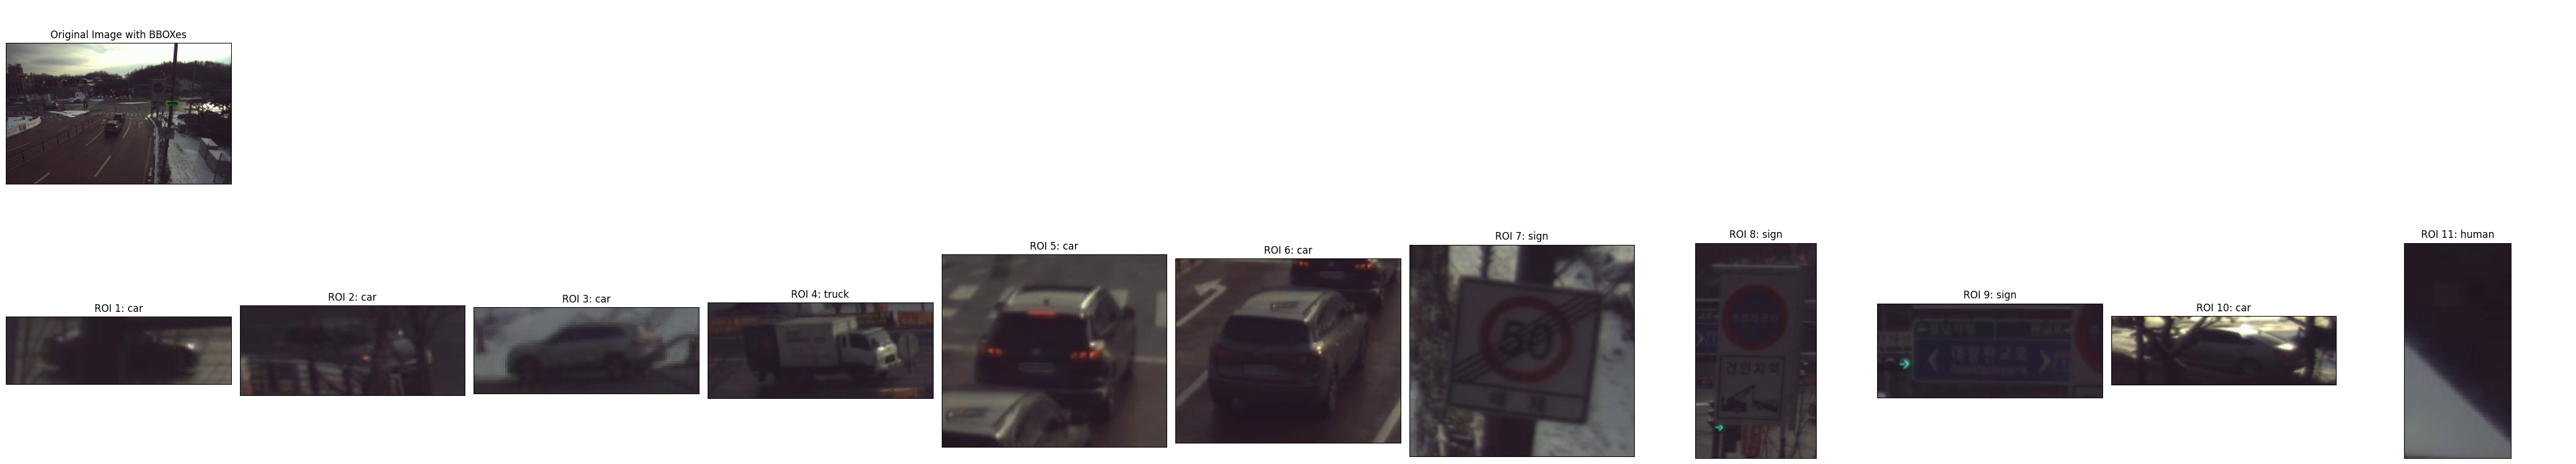

Loading image: ../train\0000002522.jpg


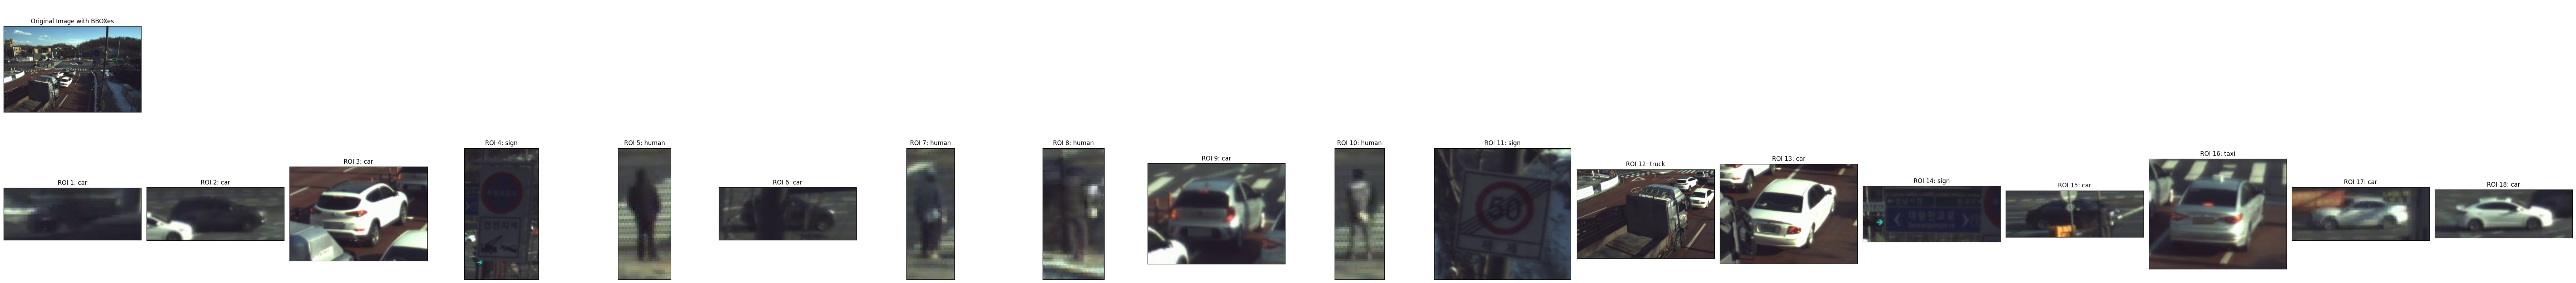

Loading image: ../train\0000016115.jpg


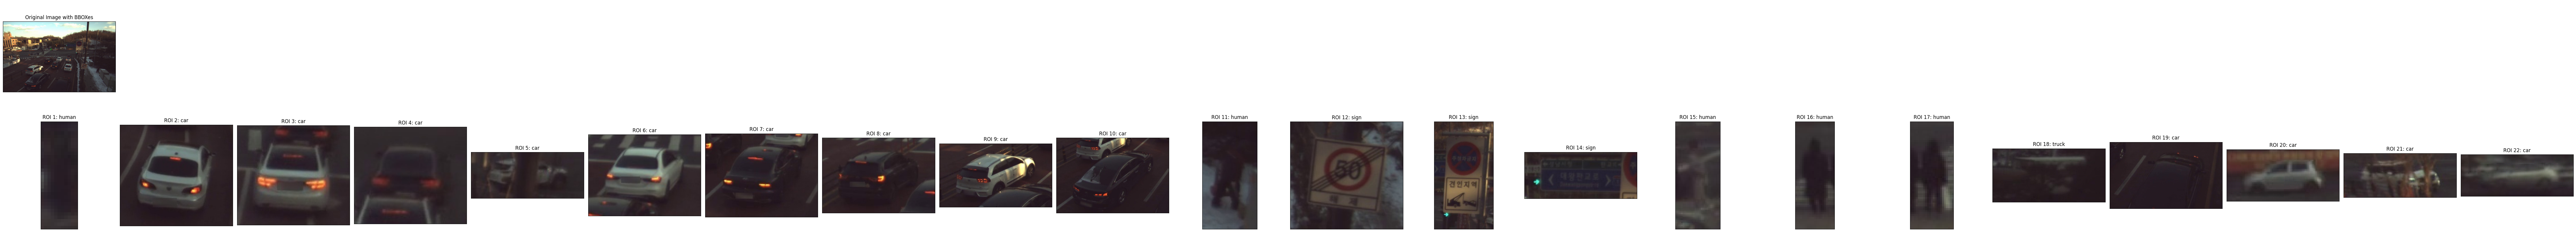

In [7]:
def visualize_roi_samples(dataset_prep, num_samples=5):
    """ROI 샘플들을 시각화"""
    # 랜덤하게 이미지 선택
    sample_img_ids = np.random.choice(
        dataset_prep.annotation_df['image_id'].unique(), 
        size=min(num_samples, len(dataset_prep.annotation_df['image_id'].unique())),
        replace=False
    )
    
    for img_id in sample_img_ids:
        # 원본 이미지 로드
        image_path = os.path.join(dataset_prep.image_dir, f"{img_id}.jpg")
        print(f"Loading image: {image_path}")  # 디버깅을 위한 출력
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
            
        # 해당 이미지의 annotation 가져오기
        img_annotations = dataset_prep.annotation_df[dataset_prep.annotation_df['image_id'] == img_id]
        
        # 시각화를 위한 subplot 생성
        n_annotations = len(img_annotations)
        fig, axes = plt.subplots(2, max(n_annotations, 1), figsize=(max(n_annotations, 1)*4, 8))
        
        # 단일 annotation인 경우 axes 형태 조정
        if n_annotations == 1:
            axes = axes.reshape(2, 1)
        
        # 원본 이미지에 bbox 표시
        img_with_bbox = image.copy()
        
        for idx, (_, ann) in enumerate(img_annotations.iterrows()):
            # 좌표를 정수로 변환
            x_min = int(ann['x_min'])
            y_min = int(ann['y_min'])
            x_max = int(ann['x_max'])
            y_max = int(ann['y_max'])
            
            # 원본 이미지에 bbox 그리기
            cv2.rectangle(
                img_with_bbox,
                (x_min, y_min),
                (x_max, y_max),
                (0, 255, 0),
                2
            )
            
            # ROI 추출
            roi = dataset_prep.extract_roi_with_padding(
                image,
                x_min, y_min,
                x_max, y_max
            )
            
            # 첫 번째 행: 원본 이미지
            if idx == 0:
                axes[0, idx].imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
                axes[0, idx].set_title('Original Image with BBOXes')
            else:
                axes[0, idx].axis('off')
            
            # 두 번째 행: ROI
            axes[1, idx].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            axes[1, idx].set_title(f'ROI {idx+1}: {ann["category_name"]}')
            
            # axis 테두리 제거
            axes[0, idx].set_xticks([])
            axes[0, idx].set_yticks([])
            axes[1, idx].set_xticks([])
            axes[1, idx].set_yticks([])
        
        plt.tight_layout()
        plt.show()

# 이미지 디렉토리 경로 설정
image_dir = '../train'

# ROI Dataset 준비 및 시각화
roi_dataset = ROIDatasetPreparation(image_dir, train_df)
visualize_roi_samples(roi_dataset, num_samples=3)